<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/VisualBERT_VQA_COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VisualBert
https://huggingface.co/docs/transformers/model_doc/visual_bert

Transformer by huggingface"

page: https://www.libhunt.com/r/transformers

Github: https://github.com/huggingface/transformers

Installation

In [1]:
!pip install -q transformers wget

     |████████████████████████████████| 4.7 MB 8.0 MB/s 
     |████████████████████████████████| 120 kB 67.6 MB/s 
     |████████████████████████████████| 6.6 MB 55.2 MB/s 


In [2]:
!git clone https://github.com/huggingface/transformers.git
%cd transformers/examples/research_projects/visual_bert

Cloning into 'transformers'...
remote: Enumerating objects: 106622, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 106622 (delta 143), reused 204 (delta 127), pack-reused 106381
Receiving objects: 100% (106622/106622), 98.68 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (78762/78762), done.
/content/transformers/examples/research_projects/visual_bert


In [1]:
%cd transformers/examples/research_projects/visual_bert

/content/transformers/examples/research_projects/visual_bert


In [ ]:
from IPython.display import Image, display
import PIL.Image
import io
import torch
import numpy as np
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils
from transformers import VisualBertForQuestionAnswering, BertTokenizerFast

# URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"
#URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"
URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt"

# load object, attribute, and answer labels

objids = utils.get_data(OBJ_URL);
attrids = utils.get_data(ATTR_URL);
vqa_answers = utils.get_data(VQA_URL);

# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg);
image_preprocess = Preprocess(frcnn_cfg);
images, sizes, scales_yx = image_preprocess(URL)

output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased");
visualbert_vqa = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa");

%s not found in cache or force_download set to True, downloading to %s https://s3.amazonaws.com/models.huggingface.co/bert/unc-nlp/frcnn-vg-finetuned/config.yaml /root/.cache/torch/transformers/tmp71xo0yac


Downloading:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

loading configuration file cache
%s not found in cache or force_download set to True, downloading to %s https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin /root/.cache/torch/transformers/tmp9jvrf0dm


Downloading:   0%|          | 0.00/262M [00:00<?, ?B/s]

loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
]

# Very important that the boxes are normalized
features = output_dict.get("roi_features")

for test_question in test_questions_for_url2:
    test_question = [test_question]

    inputs = bert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    output_vqa = visualbert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_embeds=features,
        visual_attention_mask=torch.ones(features.shape[:-1]),
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["logits"].argmax(-1)
    print("Question:", test_question)
    print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])


Question: ['Where is the cat?']
prediction from VisualBert VQA: outside
Question: ['What is near the disk?']
prediction from VisualBert VQA: nothing
Question: ['What is the color of the table?']
prediction from VisualBert VQA: brown
Question: ['What is the color of the cat?']
prediction from VisualBert VQA: gray
Question: ['What is the shape of the monitor?']
prediction from VisualBert VQA: square


# Ablation
Using Lib

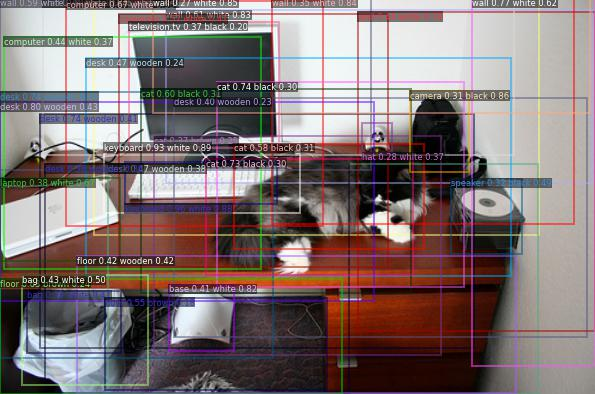

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image, display

URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
images, sizes, scales_yx = image_preprocess(URL)
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

# for visualizing output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

# add boxes and labels to the image

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())



In [ ]:
print('sizes:',sizes, 'scales_yx:',scales_yx)

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
print('Mean:',frcnn_cfg.MODEL.PIXEL_MEAN,
      '\nSTD:',frcnn_cfg.MODEL.PIXEL_STD, 
      '\nMax Input Size:',frcnn_cfg.INPUT.MAX_SIZE_TEST,
      '\nMin Input Size:',frcnn_cfg.INPUT.MIN_SIZE_TEST)

print('ROI Feature Extraction Model:',frcnn_cfg.RESNETS)

sizes: tensor([ 800, 1206]) scales_yx: tensor([0.4112, 0.4113])
loading configuration file cache
Mean: [102.9801, 115.9465, 122.7717] 
STD: [1.0, 1.0, 1.0] 
Max Input Size: 1333 
Min Input Size: 800
ROI Feature Extraction Model: resnets:
    depth: 101 (int)
    out_features: ['res4'] (list)
    num_groups: 1 (int)
    norm: BN (str)
    width_per_group: 64 (int)
    stride_in_1x1: True (bool)
    res5_dilation: 1 (int)
    res2_out_channels: 256 (int)
    stem_out_channels: 64 (int)


In [ ]:
URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
img = Image.open(requests.get(URL, stream=True).raw)
raw_sizes = torch.tensor(np.array(img).shape[:2])
sizes = torch.tensor([800, 1206])
scales_yx = torch.true_divide(raw_sizes, sizes)
print('raw_sizes, sizes, scales_yx:',raw_sizes, sizes, scales_yx)

raw_sizes, sizes, scales_yx: tensor([329, 496]) tensor([ 800, 1206]) tensor([0.4112, 0.4113])


W/O Lib (Ignoring resize Augmentation)

roi_features: torch.Size([1, 36, 2048]) boxes: torch.Size([1, 36, 4]) obj_ids: torch.Size([1, 36]) attr_ids: torch.Size([1, 36])


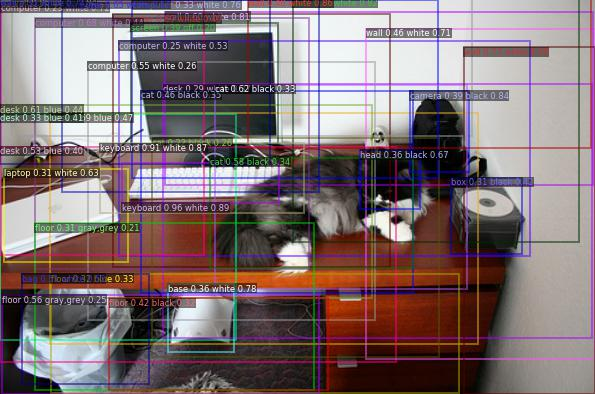

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import requests

URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
img_raw = Image.open(requests.get(URL, stream=True).raw)
raw_sizes = torch.tensor(np.array(img_raw).shape[:2])
sizes = torch.tensor([800, 1206])
scales_yx = torch.true_divide(raw_sizes, sizes)

pil_image = img_raw.resize((1206, 800), Image.BILINEAR) # PIL image wxh where other lib hxw
normalizer = lambda x: (x - [102.9801, 115.9465, 122.7717]) / [1.0, 1.0, 1.0] 
images_mine = torch.tensor(normalizer(np.array(pil_image))).double().permute(2, 0,1)[None]

output_dict = frcnn(
    images_mine.float(),
    torch.tensor([[800, 1206]]),
    scales_yx=torch.tensor([[0.4112, 0.4113]]),
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

print('roi_features:',output_dict.get("roi_features").shape, 'boxes:', output_dict.get("boxes").shape,
      'obj_ids:', output_dict.get("obj_ids").shape, 'attr_ids:', output_dict.get("attr_ids").shape,)
# for visualizing output

def showarray(a, fmt="jpeg"):
    from IPython.display import Image, display
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

# add boxes and labels to the image

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())



Display all images:

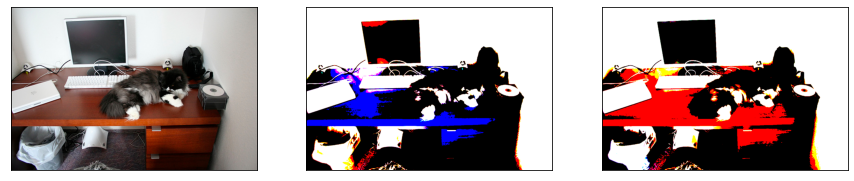

In [ ]:
num_img = 3
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(np.array(img_raw))
ax[1].imshow(images[0].permute(1,2,0))
ax[2].imshow(images_mine[0].permute(1,2,0))

VQA

In [ ]:
features = output_dict.get("roi_features")
print('roi_features',features.shape)
inputs = bert_tokenizer(
        ["Where is the cat?"],
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

print(inputs['attention_mask'].shape)
output_vqa = visualbert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_embeds=features,
    visual_attention_mask=torch.ones(features.shape[:-1]),
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

pred_vqa = output_vqa["logits"].argmax(-1)
print("Question:", test_question)
print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])

roi_features torch.Size([1, 36, 2048])
torch.Size([1, 20])
Question: ['What is the shape of the monitor?']
prediction from VisualBert VQA: outside


In [ ]:
from transformers import BertTokenizer, VisualBertModel, VisualBertForQuestionAnswering

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased");
model = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa");
model.num_labels = 2
model.cls = torch.nn.Linear(model.cls.in_features, 2)
text = "Who is eating the apple?"
inputs = tokenizer([text], return_tensors="pt", padding="max_length",max_length=20,);
print('Inputs Keys Before Visual Features:', inputs.keys())
visual_embeds = output_dict.get("roi_features")#.unsqueeze(0)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float)

inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

print('Inputs Keys After Visual Features:', inputs.keys())

labels = torch.tensor([[0.0, 1.0]]).unsqueeze(0)  # Batch size 1, Num labels 2
outputs = model(**inputs, labels=labels)
#loss = outputs.loss
scores = outputs.logits

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased");
model = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa");

In [ ]:
model.visual_bert.embeddings

VisualBertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=1)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (visual_token_type_embeddings): Embedding(2, 768)
  (visual_position_embeddings): Embedding(512, 768)
  (visual_projection): Linear(in_features=2048, out_features=768, bias=True)
)

In [ ]:
! pip -q install transformers

In [3]:
from transformers import VisualBertForQuestionAnswering, BertTokenizerFast, BertTokenizer
VisualBertForQuestionAnswering(12)

ValueError: ignored

In [1]:
%cd transformers/examples/research_projects/visual_bert

import utils
VQA_URL = "https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt"
vqa_answers = utils.get_data(VQA_URL);

/content/transformers/examples/research_projects/visual_bert


In [2]:
from IPython.display import Image, display
import PIL.Image
import io
import torch
import numpy as np
from transformers import VisualBertForQuestionAnswering, BertTokenizerFast, BertTokenizer
from PIL import Image
import requests
from utils import Config
from modeling_frcnn import GeneralizedRCNN

def seed_everything(seed=12):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()    

URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
img_raw = Image.open(requests.get(URL, stream=True).raw)
raw_sizes = torch.tensor(np.array(img_raw).shape[:2])
sizes = torch.tensor([800, 1206])
scales_yx = torch.true_divide(raw_sizes, sizes)

pil_image = img_raw.resize((1206, 800), Image.BILINEAR) # PIL image wxh where other lib hxw
normalizer = lambda x: (x - [102.9801, 115.9465, 122.7717]) / [1.0, 1.0, 1.0] 
images_mine = torch.tensor(normalizer(np.array(pil_image))).double().permute(2, 0,1)[None]

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg);
output_dict = frcnn(
    images_mine.float(),
    torch.tensor([[800, 1206]]),
    scales_yx=torch.tensor([[0.4112, 0.4113]]),
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

print('roi_features:',output_dict.get("roi_features").shape, 'boxes:', output_dict.get("boxes").shape,
      'obj_ids:', output_dict.get("obj_ids").shape, 'attr_ids:', output_dict.get("attr_ids").shape,)

test_question = ["Where is the cat?"]
#tokenizer = BertTokenizer.from_pretrained("bert-base-uncased");
# inputs = tokenizer(test_question, return_tensors="pt", padding="max_length",max_length=20,);
bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased");
inputs = bert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

model = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa");
#model.num_labels = 2
#model.cls = torch.nn.Linear(model.cls.in_features, 2)
print('Inputs Keys Before Visual Features:', inputs.keys())
visual_embeds = output_dict.get("roi_features")#.unsqueeze(0)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float)

inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

print('Inputs Keys After Visual Features:', inputs.keys())

labels = torch.tensor([[0.0, 1.0]]).unsqueeze(0)  # Batch size 1, Num labels 2
model.eval()
outputs = model(**inputs, labels=None)
#loss = outputs.loss
logits = outputs.logits
print(logits[0,:3])
pred_vqa = logits.argmax(-1)
print("Question:", test_question)
print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


roi_features: torch.Size([1, 36, 2048]) boxes: torch.Size([1, 36, 4]) obj_ids: torch.Size([1, 36]) attr_ids: torch.Size([1, 36])
Inputs Keys Before Visual Features: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Inputs Keys After Visual Features: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'visual_embeds', 'visual_token_type_ids', 'visual_attention_mask'])
sequence_output: tensor([-0.0418, -0.5736, -0.7710], grad_fn=<SliceBackward0>)
pooled_output: tensor([-0.4210,  0.0459, -0.7190], grad_fn=<SliceBackward0>)
tensor([-6.6768,  1.1085, -2.5796], grad_fn=<SliceBackward0>)
Question: ['Where is the cat?']
prediction from VisualBert VQA: outside


In [7]:
from torch import nn
from transformers import VisualBertModel, VisualBertConfig

# Initializing a VisualBERT visualbert-vqa-coco-pre style configuration
config = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
class VisualBertEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))

        # For Visual Features
        # Token type and position embedding for image features
        self.visual_token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        self.visual_position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)

        if config.special_visual_initialize:
            self.visual_token_type_embeddings.weight.data = nn.Parameter(
                self.token_type_embeddings.weight.data.clone(), requires_grad=True
            )
            self.visual_position_embeddings.weight.data = nn.Parameter(
                self.position_embeddings.weight.data.clone(), requires_grad=True
            )

        self.visual_projection = nn.Linear(config.visual_embedding_dim, config.hidden_size)


    def forward(
        self,
        input_ids=None,
        token_type_ids=None,
        position_ids=None,
        inputs_embeds=None,
        visual_embeds=None,
        visual_token_type_ids=None,
        image_text_alignment=None,
    ):

        input_shape = input_ids.size()
        seq_length = input_shape[1]
        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length]

        print('bef', input_ids.shape)
        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        
        print('af', inputs_embeds.shape)

        print('token_type_ids', token_type_ids.shape)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        print('token_type_embeddings', token_type_embeddings.shape)
        embeddings = inputs_embeds + token_type_embeddings

        # Absolute Position Embeddings
        position_embeddings = self.position_embeddings(position_ids)
        embeddings += position_embeddings

        print('before:',visual_embeds.shape)
        visual_embeds = self.visual_projection(visual_embeds)
        print('after:',visual_embeds.shape)
        print('bef', visual_token_type_ids.shape)
        visual_token_type_embeddings = self.visual_token_type_embeddings(visual_token_type_ids)
        print('af', visual_token_type_embeddings.shape)
        visual_position_ids = torch.zeros(
            *visual_embeds.size()[:-1], dtype=torch.long, device=visual_embeds.device
        )
        print('bef',visual_position_ids.shape)
        visual_position_embeddings = self.visual_position_embeddings(visual_position_ids)
        print('bef',visual_position_embeddings.shape)
        visual_embeddings = visual_embeds + visual_position_embeddings + visual_token_type_embeddings
        print('visual_embeddings', visual_embeddings.shape)
        embeddings = torch.cat((embeddings, visual_embeddings), dim=1)

        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

from torch import nn
class VisualBERT_VQA(nn.Module):
    def __init__(self, num_labels=2):
        super(VisualBERT_VQA, self).__init__()
        self.config = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
        #config.num_labels = 2
        self.visualbertvqa = VisualBertForQuestionAnswering(self.config).from_pretrained("uclanlp/visualbert-vqa");
        #self.visualbertvqa.num_labels = 2
        #self.visualbertvqa.cls = torch.nn.Linear(self.visualbertvqa.cls.in_features, 2)
        # model.visual_bert.encoder
        # model.visual_bert.pooler
        # model.dropout
        # model.cls

    def forward(self, inputs):
        #logits = self.visualbertvqa(**inputs, labels=None)
        #logits = model(**inputs, labels=None)
        # logits = self.visualbertvqa(
        #     input_ids=inputs['input_ids'],
        #     token_type_ids=inputs['token_type_ids'],
        #     attention_mask=inputs['attention_mask'],
        #     visual_embeds=inputs['visual_embeds'],
        #     visual_token_type_ids=inputs['visual_token_type_ids'],
        #     visual_attention_mask=inputs['visual_attention_mask'],
        # )

        embedding_output = self.visualbertvqa.visual_bert.embeddings(
            input_ids=inputs['input_ids'],
            token_type_ids=inputs['token_type_ids'],
            position_ids=None,
            inputs_embeds=None,
            visual_embeds=inputs['visual_embeds'],
            visual_token_type_ids=inputs['visual_token_type_ids'],
            image_text_alignment=None,
        )
        visual_input_shape = inputs['visual_embeds'].size()[:-1]
        input_shape = inputs['input_ids'].size()
        batch_size, seq_length  = input_shape
        combined_attention_mask = torch.cat((inputs['attention_mask'], inputs['visual_attention_mask']), dim=-1)
        extended_attention_mask: torch.Tensor = self.visualbertvqa.visual_bert.get_extended_attention_mask(
            combined_attention_mask, (batch_size, input_shape + visual_input_shape)
        )
        head_mask = None
        head_mask = self.visualbertvqa.visual_bert.get_head_mask(head_mask, self.config.num_hidden_layers)
        output_attentions, output_hidden_states = self.config.output_attentions, self.config.output_hidden_states
        return_dict = self.config.use_return_dict
        encoder_outputs = self.visualbertvqa.visual_bert.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = encoder_outputs[0]
        pooled_output = self.visualbertvqa.visual_bert.pooler(sequence_output)
        outputs = (sequence_output, pooled_output) + encoder_outputs[1:]

        sequence_output = outputs[0]
        # Get the index of the last text token
        # TO-CHECK: From the original code
        index_to_gather = inputs['attention_mask'].sum(1) - 2  # as in original code
        index_to_gather = (
            index_to_gather.unsqueeze(-1).unsqueeze(-1).expand(index_to_gather.size(0), 1, sequence_output.size(-1))
        )
        pooled_output = torch.gather(sequence_output, 1, index_to_gather)
        pooled_output = self.visualbertvqa.dropout(pooled_output)
        logits = self.visualbertvqa.cls(pooled_output)
        reshaped_logits = logits.view(-1, self.visualbertvqa.num_labels)
        #output = (reshaped_logits,) + outputs[2:]
        return reshaped_logits

seed_everything() 
model_vqa = VisualBERT_VQA(num_labels=2)
model_vqa.eval()
logits = model_vqa(inputs)
print(logits[0,:3])
pred_vqa = logits.argmax(-1)
print("Question:", test_question)
print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])


tensor([-6.6768,  1.1085, -2.5796], grad_fn=<SliceBackward0>)
Question: ['Where is the cat?']
prediction from VisualBert VQA: outside


In [ ]:
emb.shape

torch.Size([1, 56, 768])

In [ ]:
from transformers import VisualBertModel, VisualBertConfig

# Initializing a VisualBERT visualbert-vqa-coco-pre style configuration
configuration = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

In [ ]:
configuration.vocab_size

30522

In [ ]:
from torch import Tensor, device, nn
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import warnings

def get_extended_attention_mask(
    self, attention_mask: Tensor, input_shape: Tuple[int], device: device = None, dtype: torch.float = None
) -> Tensor:
    if dtype is None:
        dtype = self.dtype

    if not (attention_mask.dim() == 2 and self.config.is_decoder):
        # show warning only if it won't be shown in `create_extended_attention_mask_for_decoder`
        if device is not None:
            warnings.warn(
                "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
            )
    # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
    # ourselves in which case we just need to make it broadcastable to all heads.
    if attention_mask.dim() == 3:
        extended_attention_mask = attention_mask[:, None, :, :]
    elif attention_mask.dim() == 2:
        # Provided a padding mask of dimensions [batch_size, seq_length]
        # - if the model is a decoder, apply a causal mask in addition to the padding mask
        # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder:
            extended_attention_mask = ModuleUtilsMixin.create_extended_attention_mask_for_decoder(
                input_shape, attention_mask, device
            )
        else:
            extended_attention_mask = attention_mask[:, None, None, :]
    else:
        raise ValueError(
            f"Wrong shape for input_ids (shape {input_shape}) or attention_mask (shape {attention_mask.shape})"
        )

    extended_attention_mask = extended_attention_mask.to(dtype=dtype)  # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(dtype).min
    return extended_attention_mask

def get_head_mask(
    self, head_mask: Optional[Tensor], num_hidden_layers: int, is_attention_chunked: bool = False
) -> Tensor:
    if head_mask is not None:
        head_mask = self._convert_head_mask_to_5d(head_mask, num_hidden_layers)
        if is_attention_chunked is True:
            head_mask = head_mask.unsqueeze(-1)
    else:
        head_mask = [None] * num_hidden_layers

    return head_mask

In [ ]:
from torch import nn
class VisualBERT_VQA(nn.Module):
    def __init__(self, num_labels=2):
        super(VisualBERT_VQA, self).__init__()
        self.visualbertvqa = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa");
        #self.embeddings = VisualBertEmbeddings(config)
        self.num_labels = num_labels
        self.cls = nn.Linear(768, num_labels)

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        visual_embeds: Optional[torch.FloatTensor] = None,
        visual_attention_mask: Optional[torch.LongTensor] = None,
        visual_token_type_ids: Optional[torch.LongTensor] = None,
        image_text_alignment: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):

        embedding_output = self.visualbertvqa.visual_bert.embeddings(
            input_ids=input_ids,
            position_ids=None,
            token_type_ids=token_type_ids,
            inputs_embeds=None,
            visual_embeds=visual_embeds,
            visual_token_type_ids=visual_token_type_ids,
            image_text_alignment=None,
        )

        input_shape = input_ids.size()
        visual_input_shape = visual_embeds.size()[:-1]
        batch_size, seq_length = input_shape
        device = input_ids.device if input_ids is not None else inputs_embeds.device

        if visual_embeds is not None:
            combined_attention_mask = torch.cat((attention_mask, visual_attention_mask), dim=-1)
            extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(
                combined_attention_mask, (batch_size, input_shape + visual_input_shape)
        )
        
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = encoder_outputs[0]
        output = BaseModelOutputWithPooling(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )
        sequence_output = output[0]

        index_to_gather = attention_mask.sum(1) - 2  # as in original code
        index_to_gather = (
            index_to_gather.unsqueeze(-1).unsqueeze(-1).expand(index_to_gather.size(0), 1, sequence_output.size(-1))
        )
        pooled_output = torch.gather(sequence_output, 1, index_to_gather)

        pooled_output = self.dropout(pooled_output)
        logits = self.cls(pooled_output)
        reshaped_logits = logits.view(-1, self.num_labels)



        return reshaped_logits


outputs = model(
    input_ids=inputs['input_ids'],
    token_type_ids=inputs['token_type_ids'],
    attention_mask=inputs['attention_mask'],
    visual_embeds=inputs['visual_embeds'],
    visual_token_type_ids=inputs['visual_token_type_ids'],
    visual_attention_mask=inputs['visual_attention_mask'],
)

NameError: ignored

In [ ]:
print('Inputs Keys After Visual Features:', inputs.keys())

NameError: ignored

In [ ]:
model

VisualBertForQuestionAnswering(
  (visual_bert): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=2048, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0): VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         